In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, wait
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
import project_path
from src.util.generate_connected_graph import generate_connected_graph
from src.util.generate_lr_data import generate_low_rank_data
from src.util.generate_anomaly import generate_spatio_temporal_anomaly
from src.algos.lr_stss import lr_stss

In [2]:
client = Client(threads_per_worker=1, n_workers=125)
client

<Client: 'tcp://127.0.0.1:43617' processes=125 threads=125, memory=40.00 GiB>

In [4]:
## Control Variables
gt = 'grid'
graph_param = (8,5)
dtn = 4
rad =1
amp =1
window = 'boxcar'
distribution = 'bernoulli'
local_distribution = 'constant'
dims = (40,24,7,4)
ranks = (8,8,5,4)
NoG = 1
NoT = 3
time_m = 2
local_m = 1
lda_2 = 100
psi = 20
maxit = 300
maxit2 = 40
## Independent variables
### Hyperparameters
NoA = np.array([25,50,125,250,500])
lda_1 = np.logspace(1,-3,5)
lda_l = np.logspace(1,-3,5)
lda_t = np.logspace(1,-3,5)

metadata = {'graph_type': gt,
            'graph_param': graph_param,
            'number_of_anomalies': NoA,
            'anomaly_duration': dtn,
            'anomaly_radius': rad,
            'anomaly_amplitude': amp,
            'window': window,
            'distribution': distribution,
            'local_distribution': local_distribution,
            'number_of_graphs': NoG,
            'number_of_trials': NoT,
            'ranks':ranks,
            'dims':dims,
            'time_mode': time_m,
            'local_mode': local_m,
            'lda_2':lda_2,
            'lda_1':lda_1,
            'lda_l':lda_l,
            'lda_t':lda_t,
            'psi': psi,
            'maxit':maxit,
            'maxit2':maxit2,
            }

# Define experiment function
def run_exp(X, Y, an_m, inputs):
    G = inputs['G']
    A = nx.adjacency_matrix(G)
    Deg = np.diag(np.asarray(np.sum(A,axis=1)).ravel())
    Dsq = np.linalg.inv(np.sqrt(Deg))
    An = Dsq@A@Dsq
    Y = inputs['Y']
    Y = np.ma.masked_array(Y, mask=np.zeros(dims,dtype=bool))
    X = inputs['X']
    an_m = inputs['an_m']
    psi = inputs['psi']
    res = lr_stss(Y, An, time_m,local_m, verbose=0, max_it2=40, max_it=300,
        lda2=inputs['lda_2'], lda1=inputs['lda_1'], lda_t=inputs['lda_t'],
        lda_loc=inputs['lda_l'], psis=[psi,psi,psi,psi])
    
    result = {'graph_type': gt,
              'auc': roc_auc_score(an_m.ravel(),np.abs(res['S']).ravel()),
              'rec_err': np.linalg.norm(res['X']-X)/np.linalg.norm(X),
              'anomaly_cardinality': an_m.sum(),
              'number_of_anomalies': inputs['NoA'],
              'anomaly_duration': dtn,
              'anomaly_radius': rad,
              'graph_seed': inputs['graph_seed'],
              'anomaly_seed': inputs['anomaly_seed'],
              'anomaly_amplitude': amp,
              'lda_1': inputs['lda_1'],
              'lda_2': inputs['lda_2'],
              'lda_l': inputs['lda_l'],
              'lda_t': inputs['lda_t'],
              'psi_1': inputs['psi'], 'psi_2': inputs['psi'],
              'psi_3': inputs['psi'], 'psi_4': inputs['psi'],
              'maxit': maxit, 'maxit2': maxit2,
              'it': res['it']}
    return result

In [5]:
try:
    del futures
except:
    pass
futures = []
seed = 12345678
input = {}
for i in range(NoG):
    G,sd = generate_connected_graph(graph_param, gt, radius=graph_param, seed=seed)
    input['G'] = G
    input['graph_type'] = gt
    input['graph_seed'] = sd
    seed = sd
    for j in range(NoT):
        
        for k in range(len(NoA)):
            # Generate low rank normal data
            X = generate_low_rank_data(dims, ranks, seed)
            X = 1*X/np.std(X)
            input['X'] = X
            # Generate anomaly
            an, an_m = generate_spatio_temporal_anomaly(dims, G, NoA[k], duration=dtn,
                                                        radius=rad, seed=seed,
                time_m=time_m, local_m=local_m, window_type='boxcar', amplitude=amp,
                distribution=distribution, local_dist='constant')
            input['anomaly_seed'] = seed
            input['an_m'] = an_m
            input['NoA'] = NoA[k]
            Y = X+an
            # Y = np.ma.masked_array(Y, mask=np.zeros(dims,dtype=bool))
            input['Y'] = Y
            seed +=1
            for k1 in range(len(lda_1)):
                for k2 in range(len(lda_l)):
                    for k3 in range(len(lda_t)):
                        input['lda_1'] = lda_1[k1]
                        input['lda_l'] = lda_l[k2]
                        input['lda_t'] = lda_t[k3]
                        input['lda_2'] = lda_2
                        input['psi'] = psi
                        futures.append(client.submit(run_exp, X, Y, an_m, input))
            

Graph is connected.


In [6]:
progress(futures)

VBox()

2023-06-26 09:18:04,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:07,763 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:08,043 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:18:42,608 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:44,012 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:44,511 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:18:54,066 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:54,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:54,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:18:59,001 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:59,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:18:59,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:05,818 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:05,829 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:05,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:09,469 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:09,600 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:09,878 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:14,562 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:14,711 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:14,750 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:17,816 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:17,819 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:17,883 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:21,638 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:21,684 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:21,853 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:26,012 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:26,160 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:26,641 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:29,100 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:29,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:29,347 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:33,825 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 228.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:33,950 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:34,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:36,987 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:37,066 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:37,190 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:39,997 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:40,108 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:40,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:44,812 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:44,875 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:44,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:48,078 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:48,082 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:48,456 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:50,929 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:51,024 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:51,080 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:55,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:55,099 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:55,116 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:19:58,180 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:58,182 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:19:58,556 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:01,027 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:01,029 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:01,080 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:04,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:04,692 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:04,763 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:07,167 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:07,287 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:07,293 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:09,462 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:09,499 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:09,546 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:11,735 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:11,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:12,036 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:15,100 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:15,147 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 228.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:15,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:17,563 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:17,750 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:17,800 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:19,770 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:19,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:19,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:21,833 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:21,989 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:22,136 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:25,076 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:25,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:25,199 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:27,011 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:27,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:27,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:29,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:29,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:29,560 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:31,396 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:31,625 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:31,657 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:33,615 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:33,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:34,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:36,419 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:36,511 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:36,663 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:38,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:38,382 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:38,418 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:40,117 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:40,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:40,343 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:42,237 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:42,379 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:42,425 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:45,115 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:45,210 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:45,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:47,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:47,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:47,404 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:49,361 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:49,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:49,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:51,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:51,095 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:51,188 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:52,552 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:52,639 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:52,830 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:55,214 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:55,278 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:55,342 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:57,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:57,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:57,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:20:59,124 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:59,172 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:20:59,296 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:00,738 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 229.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:00,807 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:01,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:02,227 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:02,285 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:02,285 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:05,107 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:05,163 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:05,215 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:07,041 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:07,067 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:07,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:09,224 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:09,274 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:09,393 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:10,808 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:10,831 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:11,184 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:12,438 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:12,480 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:12,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:15,206 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:15,262 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:15,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:17,075 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:17,143 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:17,166 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:18,956 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 236.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:18,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:19,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:20,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:20,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 230.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:20,905 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:22,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:22,327 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:22,438 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:25,139 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:25,207 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:25,262 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:27,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:27,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:27,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:29,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:29,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:29,373 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:30,642 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:30,710 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:30,732 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:32,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:32,233 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:32,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:34,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:34,051 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:34,650 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:36,439 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:36,530 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 235.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:36,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:38,404 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 231.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:38,432 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:38,503 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:40,168 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 237.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:40,266 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:40,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:41,852 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:41,892 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:41,927 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:43,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 232.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:43,807 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:43,837 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:21:46,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 234.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:46,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 233.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:21:46,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

In [8]:
from dask.distributed import as_completed
fname = 'lr_stss_exp1_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)
for future in as_completed(futures):
    df = pd.DataFrame(future.result(), index=[i])
    with pd.HDFStore(fname) as storedata:
        storedata.append(key, df)
    del future

with pd.HDFStore(fname) as storedata:
    storedata.get_storer(key).attrs.metadata=metadata

2023-06-26 09:24:10,371 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:10,423 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:10,462 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:12,004 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:12,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:12,128 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:13,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 239.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:13,585 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:13,725 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:16,261 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:16,275 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:16,314 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:18,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:18,903 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:19,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:20,699 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:20,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:20,723 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:22,228 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:22,280 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:22,288 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:23,684 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:23,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:23,754 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:26,456 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:26,550 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:26,611 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:28,511 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:28,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:28,765 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:30,635 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:30,713 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:30,723 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:32,193 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:32,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:32,378 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:33,685 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:33,836 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:33,853 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:36,711 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:36,799 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:36,815 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:39,003 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:39,062 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:39,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:40,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:40,946 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:41,158 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:42,656 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:42,685 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:42,761 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:44,079 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:44,140 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:44,324 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:46,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:46,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:46,656 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:48,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:48,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:48,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:50,822 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 240.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:50,833 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:50,899 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:52,511 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:52,754 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:52,788 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:54,178 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:54,241 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:54,325 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:56,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:56,656 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:56,748 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:24:58,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:58,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:24:58,866 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:00,623 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:00,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 241.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:00,761 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:02,141 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:02,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:02,331 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:03,885 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:03,954 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:04,026 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:06,538 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:06,560 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:06,562 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:08,275 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:08,276 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:08,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:10,218 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:10,235 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:10,255 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:11,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:12,010 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:12,031 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:13,526 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 242.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:13,533 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:13,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:16,309 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:16,466 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:16,517 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:18,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:18,263 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:18,275 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:20,319 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:20,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:20,355 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:22,008 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:22,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:22,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:23,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:23,513 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:23,534 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:25,849 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:25,992 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:26,127 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:28,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:28,120 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:28,275 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:30,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:30,482 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:30,594 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:32,106 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:32,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:32,209 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:33,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:33,627 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:33,633 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:35,949 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:36,092 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:36,226 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:37,931 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:38,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:38,111 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:39,903 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:39,914 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:40,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:41,680 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:41,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:41,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:43,499 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:43,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:43,614 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:45,550 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:45,637 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:45,950 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:47,739 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:47,830 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:48,031 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:49,754 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:49,904 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:49,914 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:51,550 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 243.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:51,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:51,771 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:53,323 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:53,326 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:53,374 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:55,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:55,053 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 244.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:55,106 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:57,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:57,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:57,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:25:59,490 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:59,503 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:25:59,562 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:01,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:01,399 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:01,446 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:02,986 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:03,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:03,185 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:04,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:04,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:04,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:07,156 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:07,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:07,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:09,012 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:09,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:09,269 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:11,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:11,123 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:11,160 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:12,604 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:12,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:12,780 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:14,284 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:14,437 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:14,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:16,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:16,959 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:16,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:18,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:18,776 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:18,777 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:20,972 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:20,993 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:21,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:22,987 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:23,012 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:23,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:24,679 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:24,825 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:24,839 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:27,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:27,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:27,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:28,967 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:29,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:29,311 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:31,260 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:31,321 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 245.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:31,336 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:32,704 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:32,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:32,895 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:34,232 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:34,285 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:34,553 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:37,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:37,075 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:37,135 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:38,840 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:38,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:38,923 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:41,323 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:41,336 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:41,413 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:42,830 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:42,979 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:42,993 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:44,553 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:44,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:44,725 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:47,138 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:47,164 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:47,302 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:49,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:49,566 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:49,704 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:51,335 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:51,360 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:51,414 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:52,705 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 246.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:52,709 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:52,831 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:54,311 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:54,332 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:54,484 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:57,005 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:57,061 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:57,076 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:26:59,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:59,121 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:26:59,518 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:01,422 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 247.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:01,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:01,513 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:03,079 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:03,093 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:03,186 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:04,585 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:04,653 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:04,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:07,940 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:08,429 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:08,430 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:10,402 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:10,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:10,576 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:12,056 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:12,169 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:12,268 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:13,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:13,994 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:14,027 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:15,755 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:16,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:16,052 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:18,026 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:18,041 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:18,429 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:20,501 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:20,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:20,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:22,376 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:22,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:22,496 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:23,994 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:24,027 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:24,114 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:26,016 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:26,151 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:26,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:28,430 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:28,530 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:28,594 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:30,403 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 248.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:30,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:30,501 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:32,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:32,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:32,271 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:33,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:33,995 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:34,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:36,115 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:36,250 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:36,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:38,395 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:38,529 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:38,531 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:40,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:40,601 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:40,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:42,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:42,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:42,369 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:44,052 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:44,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:44,313 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:45,836 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:45,953 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:46,214 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:48,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:48,221 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:48,444 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:50,348 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:50,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:50,359 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:52,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 249.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:52,166 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:52,170 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:53,864 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:53,874 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:53,899 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:55,852 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:55,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:55,935 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:27:58,016 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:58,033 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:27:58,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:01,154 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:01,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:01,235 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:02,576 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:02,613 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:02,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:04,252 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:04,294 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:04,387 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:06,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:06,314 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:06,350 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:08,322 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:08,629 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:08,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:10,388 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:10,449 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:10,503 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:12,150 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:12,270 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:12,345 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:13,956 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:13,973 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:13,990 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:15,640 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:15,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:15,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:18,117 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:18,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:18,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:20,485 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:20,548 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:20,602 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:22,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 250.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:22,345 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:22,366 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:23,885 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:23,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:23,974 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:25,524 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:25,576 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:25,710 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:27,921 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:27,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:27,999 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:30,011 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:30,366 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:30,393 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:31,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:31,960 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:32,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:33,479 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:33,529 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:33,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:35,084 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:35,237 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:35,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:37,816 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:37,840 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:37,860 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:39,612 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:39,623 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:39,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:41,793 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:41,818 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:41,825 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:43,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:43,310 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:43,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:44,925 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:45,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:45,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:47,575 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:47,765 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:47,840 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:50,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:50,486 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:50,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:52,198 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:52,269 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:52,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:54,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:54,073 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:54,084 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:55,425 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:55,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:55,774 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:28:58,136 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:58,157 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:28:58,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:00,486 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:00,492 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:00,604 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:02,213 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:02,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:02,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:03,886 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 253.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:03,894 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:04,076 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:05,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:05,624 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 252.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:05,874 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:08,235 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:08,258 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:08,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:10,487 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:10,591 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:10,665 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:12,298 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:12,368 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:12,646 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:14,174 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:14,184 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:14,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:15,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:15,536 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:15,624 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:18,138 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:18,199 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:18,210 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:20,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:20,586 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:20,591 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:22,298 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:22,312 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:22,371 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:23,986 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:23,994 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:24,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:25,577 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:25,625 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:25,625 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:28,114 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:28,199 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:28,236 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:30,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:30,591 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:30,666 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:32,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:32,260 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:32,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:33,704 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:33,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:33,880 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:35,212 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:35,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:35,484 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:37,975 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:38,061 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:38,067 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:39,863 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:40,011 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:40,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:41,903 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:41,982 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:42,025 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:43,595 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:43,609 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:43,631 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:45,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:45,126 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:45,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:47,706 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:47,762 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:47,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:49,676 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:49,698 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:49,875 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:51,798 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:51,935 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:52,004 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:53,341 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:53,514 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:53,518 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:54,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:54,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:54,938 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:56,853 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:56,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:56,954 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:29:58,768 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:58,810 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:58,917 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:59,011 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:29:59,022 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:00,711 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:00,787 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:00,790 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:00,811 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:30:02,193 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:02,222 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:02,271 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:30:03,119 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:03,135 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:03,157 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:03,169 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:30:04,499 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:04,556 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:04,569 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:04,592 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:04,598 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:05,633 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:05,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:05,733 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:05,737 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:07,134 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:07,135 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:07,157 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:07,235 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:07,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:08,734 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:08,754 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:08,835 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:08,848 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:10,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:10,795 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:10,888 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:30:12,598 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:12,634 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:12,636 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:30:13,905 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:13,908 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:14,027 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:14,080 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:30:15,753 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:15,778 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:15,833 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:15,835 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:30:17,805 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:17,852 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:17,954 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:17,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:19,331 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:19,408 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:19,530 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:19,639 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:30:21,065 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:21,102 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:21,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:30:22,453 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:22,460 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:22,469 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:22,517 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:23,313 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:23,452 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:23,519 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:23,541 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:24,609 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:24,619 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:24,651 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:24,693 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:25,517 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:25,584 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:25,653 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:25,708 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:25,753 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:27,317 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:27,419 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:27,519 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:27,551 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:27,717 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:28,948 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:29,034 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:29,132 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:29,215 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:30,607 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:30,633 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:30,711 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:30,734 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:30,819 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:32,098 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:32,134 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:32,134 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:32,135 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:33,283 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:33,314 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:33,333 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:33,352 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:33,357 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:34,434 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:34,485 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:34,507 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:34,556 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:30:35,333 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:35,334 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:35,347 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:35,384 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:35,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:36,507 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:36,508 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:36,509 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:36,583 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:36,628 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:30:37,383 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:37,405 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:37,418 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:37,449 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:37,488 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:37,519 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:30:38,484 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:38,506 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:38,599 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:38,606 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:38,610 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:39,706 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:39,708 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:39,728 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:39,741 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:39,784 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:40,623 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:40,649 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:40,683 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:40,705 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:40,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:30:41,806 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:41,823 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:41,849 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:41,849 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:41,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:30:42,898 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:42,913 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:42,923 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:42,935 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:30:43,848 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:43,848 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:43,892 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:43,895 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:43,905 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:30:44,792 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:44,798 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:44,801 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 254.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:44,810 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:30:45,749 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:45,749 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:45,750 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:45,769 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 258.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:45,771 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:45,784 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:30:46,812 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:46,850 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:46,872 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:46,905 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:46,912 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:30:47,892 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:47,910 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:47,949 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:47,949 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:47,967 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:30:48,645 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:48,648 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:48,649 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:48,649 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:48,698 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:30:49,468 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:49,492 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:49,506 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:49,512 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:49,531 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:30:50,117 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,134 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,149 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,203 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,212 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:30:50,740 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,769 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,778 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.78 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,812 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:50,833 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:51,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:51,380 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:51,405 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:51,439 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:51,470 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:52,212 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,234 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,234 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,246 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,278 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:52,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,903 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,933 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,946 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:52,964 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:53,511 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:53,534 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:53,537 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:53,545 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:53,606 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:53,611 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:30:54,211 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,229 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,239 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,262 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,268 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:30:54,890 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,891 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,899 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:54,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:30:55,561 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:55,576 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:55,586 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:55,599 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:55,601 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:55,613 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:30:56,185 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,190 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,203 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,210 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,232 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,238 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:30:56,799 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,802 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,810 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,834 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:56,835 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:57,611 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:57,622 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:57,691 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:57,701 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:57,711 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:57,750 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:30:58,447 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:58,461 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:58,484 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:58,503 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:58,514 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:30:59,512 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:59,539 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:59,561 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:59,614 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:30:59,631 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:31:00,135 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,139 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,145 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,171 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,176 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,186 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:00,748 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,749 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,793 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,814 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,832 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:00,837 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:01,376 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:01,385 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:01,402 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:01,411 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:01,413 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:01,999 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,004 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,011 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,011 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,013 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,036 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:02,437 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,440 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 255.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,476 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,486 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,494 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,498 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:02,868 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,875 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,886 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,910 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:02,911 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:03,276 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,286 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,298 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,302 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:03,924 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,928 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,930 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,948 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:03,956 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:04,531 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,556 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,560 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,561 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,577 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:04,961 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,966 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,978 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,981 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,990 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:04,999 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:31:05,612 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:05,615 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:05,628 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:05,655 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:05,666 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:06,236 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,239 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,253 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,256 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:06,878 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,887 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,891 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,893 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:06,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:31:07,499 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:07,513 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:07,513 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:07,528 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:07,537 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:07,566 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:08,165 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:08,178 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:08,192 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:08,200 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:08,204 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:08,227 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:09,300 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:09,313 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:09,336 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:09,356 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:09,359 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:09,366 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:10,194 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,210 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 257.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,214 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,214 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,230 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,240 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:10,837 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,865 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,874 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,891 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,900 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:10,912 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:11,501 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:11,515 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:11,515 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:11,552 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:11,567 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:12,364 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:12,384 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:12,393 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:12,394 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:12,397 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:12,975 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:12,994 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,014 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,014 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,021 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,035 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:13,597 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,616 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,622 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,623 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:13,642 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:14,222 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,261 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,269 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,295 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,298 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,322 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:14,911 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,914 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,923 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,939 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,959 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:14,975 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:15,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:15,365 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:15,366 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:15,369 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:15,414 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:16,016 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,021 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,028 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,039 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,069 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,075 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:16,635 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,639 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,696 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,700 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:16,707 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:31:17,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,268 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,273 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,297 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,298 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:17,891 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,893 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,895 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,913 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,921 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:17,935 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:18,391 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:18,395 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:18,396 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:18,421 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:18,426 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:18,435 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:19,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,166 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,176 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,190 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,195 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:19,773 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,775 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,777 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,786 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,797 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:19,815 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:20,185 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,197 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,197 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,203 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:20,595 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,598 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,598 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,622 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,632 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:20,634 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:21,021 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,021 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,026 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,031 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,030 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,035 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:21,437 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,438 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,448 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,451 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.26 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:21,467 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:22,096 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,113 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,114 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,123 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,136 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,138 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:22,511 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,522 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,524 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,532 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,538 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,541 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:22,917 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,921 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,924 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:22,949 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:31:23,359 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,363 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,369 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,377 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,395 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:23,766 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,796 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,825 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,846 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,867 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:23,878 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:24,393 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:24,414 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:24,425 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.49 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:24,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:24,455 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:25,025 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,028 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,068 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,074 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,077 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:25,696 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,713 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:25,727 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:31:26,335 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:26,335 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:26,342 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:26,356 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:26,361 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:26,377 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:27,206 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:27,207 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:27,252 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:27,254 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:31:28,284 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:28,292 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 258.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:28,329 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:28,343 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:28,356 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.08 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:28,360 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:29,342 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:29,365 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:29,374 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:29,375 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:29,389 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:29,393 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:29,994 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,018 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,039 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,042 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:31:30,912 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,927 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,935 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,942 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,953 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:30,959 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:31,560 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:31,563 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:31,593 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:31,621 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:31,652 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:31,653 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:31:32,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:32,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 266.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:32,457 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.67 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:32,460 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:31:33,067 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,076 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,094 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,099 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,132 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:33,713 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,742 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,752 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:33,780 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:31:34,353 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:34,404 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:34,422 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:34,426 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:34,427 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:35,011 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,017 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,052 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,084 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,090 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:35,876 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,896 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,930 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,935 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,951 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:35,965 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:36,583 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:36,607 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:36,612 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:36,638 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:36,651 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:37,240 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:37,274 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:37,305 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:37,341 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:37,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:38,116 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:38,127 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:38,134 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:38,205 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:38,206 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:38,992 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:38,995 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,000 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,010 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 267.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,013 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:39,827 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,840 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,856 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,856 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:39,894 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:40,810 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:40,825 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:40,826 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:40,834 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:40,892 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:40,911 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:41,653 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:41,673 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:41,675 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:41,697 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:41,705 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:42,304 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,305 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,327 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,332 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,339 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,341 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:42,934 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,952 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,968 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:42,990 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:43,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:43,556 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:43,557 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:43,566 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:31:44,193 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:44,205 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:44,210 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:44,227 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:31:45,051 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,085 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,091 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,106 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:31:45,708 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,733 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,739 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,742 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:45,784 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:31:46,404 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:46,405 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:46,426 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:46,431 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.00 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:46,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:47,354 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:47,362 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:47,394 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:47,406 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:47,407 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:48,293 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:48,304 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:48,306 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:48,351 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:48,352 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:48,968 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:48,994 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,004 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,007 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,007 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,010 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:31:49,861 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,864 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,906 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:49,976 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:50,013 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:50,029 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:31:50,976 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:51,056 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.41 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:51,067 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:51,103 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:51,105 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:51,157 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:31:52,000 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:52,006 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:52,013 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 264.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:52,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:52,039 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:52,910 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:52,936 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:52,965 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:53,023 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:31:54,010 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,039 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,075 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,096 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,118 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:54,852 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,865 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,906 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,950 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:54,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:31:55,734 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:55,766 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:55,775 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:55,785 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:55,811 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:31:56,624 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:56,674 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:56,704 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:56,711 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:56,739 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:31:57,475 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:57,485 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:57,494 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:57,509 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.44 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:57,511 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:57,526 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:31:58,385 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:58,405 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:58,452 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:58,485 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:58,486 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:31:59,376 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.10 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:59,387 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:59,433 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:59,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:31:59,436 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:00,236 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,238 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,276 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,278 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,286 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:00,856 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,866 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,876 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,884 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:00,911 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:01,707 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:01,712 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.22 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:01,736 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:01,739 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:01,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged m

2023-06-26 09:32:02,541 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:02,551 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:02,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:02,615 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:32:03,484 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:03,533 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:03,612 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:03,637 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:03,649 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:32:04,441 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:04,476 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:04,486 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:04,528 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:04,537 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:32:05,305 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:05,307 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:05,353 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:05,398 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:06,137 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:06,153 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:06,194 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.13 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:06,201 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:06,206 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:06,211 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:32:07,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:07,074 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.39 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:07,112 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:07,119 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:07,127 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:32:07,854 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:07,925 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:07,934 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:08,025 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:08,126 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:09,011 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,012 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,020 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,024 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:09,636 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 258.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,664 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,721 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,725 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.34 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,764 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 264.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:09,810 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:32:10,699 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:10,712 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:10,725 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:10,740 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:10,763 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:32:11,322 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:11,324 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:11,366 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:11,411 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:11,421 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.90 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:11,425 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26

2023-06-26 09:32:11,934 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.14 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,010 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,026 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,034 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,052 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.24 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,060 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:32:12,835 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,872 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,905 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.40 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,906 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:12,910 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:32:13,510 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:13,512 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:13,520 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:13,525 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:13,526 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:14,406 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.86 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:14,422 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:14,434 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:14,500 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:14,528 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:32:15,452 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:15,505 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.29 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:15,523 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:15,536 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.16 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:15,599 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process m

2023-06-26 09:32:16,903 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:16,927 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:16,938 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:16,941 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:17,003 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:32:18,021 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.51 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:18,034 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:18,049 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:18,122 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:18,126 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:18,148 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 26

2023-06-26 09:32:19,104 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.54 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:19,122 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.72 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:19,139 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:19,147 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:19,211 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:32:20,210 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:20,229 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.03 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:20,239 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:20,248 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:20,375 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:32:21,284 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.63 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:21,311 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.01 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:21,324 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:21,385 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:21,391 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory 

2023-06-26 09:32:22,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.56 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:22,203 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.60 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:22,253 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:22,303 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:22,321 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:32:23,025 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:23,025 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.74 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:23,029 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:23,053 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:23,105 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process m

2023-06-26 09:32:24,002 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.85 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:24,013 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:24,040 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:24,053 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 09:32:25,138 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:25,155 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.58 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:25,175 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:25,231 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 09:32:26,032 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 266.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:26,084 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.73 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:26,123 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.99 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:26,136 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 09:32:27,698 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.59 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:27,712 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.98 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:27,784 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:27,812 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:27,825 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:27,850 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or t

2023-06-26 09:32:29,311 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 269.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:29,354 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:29,435 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.42 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:29,457 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:30,710 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 266.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:30,812 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.27 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:30,862 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:30,875 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:32,102 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:32,160 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:32,200 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:32,203 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  

2023-06-26 09:32:33,567 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.83 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:33,569 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:33,611 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:33,613 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:34,613 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.12 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:34,628 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.30 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:34,711 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 262.75 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:34,804 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:32:36,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.18 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:36,227 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.84 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:36,352 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.45 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:36,378 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:37,836 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:37,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.77 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:37,914 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 266.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:37,974 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 09:32:39,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 269.69 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:39,535 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:39,556 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:32:41,125 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 262.11 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:41,165 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.68 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:41,224 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.76 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:41,412 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Un

2023-06-26 09:32:43,103 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 267.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:43,171 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:43,221 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:32:44,503 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 263.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:44,605 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:44,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.31 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:44,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:46,183 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.91 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:46,326 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.37 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:46,374 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 257.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:46,478 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:48,491 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 267.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:48,526 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 265.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:48,535 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 259.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:48,549 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:32:50,141 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:50,328 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:50,439 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:32:52,131 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:52,325 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 261.97 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:52,358 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.88 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:52,365 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. 

2023-06-26 09:32:53,669 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.50 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:53,712 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 267.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:53,733 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:32:55,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:55,390 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:55,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:32:57,038 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:57,174 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.15 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:57,507 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:32:59,610 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.23 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:59,635 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 264.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:32:59,656 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:01,590 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:01,777 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 260.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:01,903 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.66 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:01,923 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. 

2023-06-26 09:33:03,421 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:03,459 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:03,498 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:04,827 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:05,004 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.87 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:05,132 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:06,525 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:06,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 266.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:06,583 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:08,961 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.38 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:08,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:09,214 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:10,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.09 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:10,911 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:11,162 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:12,812 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 258.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:12,955 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 262.93 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:12,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 267.64 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:12,993 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

2023-06-26 09:33:14,277 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:14,395 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.07 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:14,411 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:16,011 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.89 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:16,124 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.43 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:16,125 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:17,953 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.70 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:18,006 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:18,014 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:20,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:20,222 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.79 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:20,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:22,330 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.94 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:22,353 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:22,459 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:24,168 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.04 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:24,247 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.35 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:24,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:25,754 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:25,799 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.81 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:25,806 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:27,709 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.02 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:27,808 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.62 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:27,833 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:30,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 261.33 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:30,134 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 257.57 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:30,316 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:32,330 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.95 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:32,452 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:32,559 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:34,249 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 255.36 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:34,256 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.19 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:34,265 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:35,898 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.82 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:35,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:36,051 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:38,054 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 256.71 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:38,105 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.48 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:38,114 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:40,415 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.61 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:40,420 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.80 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:40,431 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:42,431 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.96 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:42,453 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.21 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:42,561 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:44,257 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.20 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:44,340 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.32 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:44,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:45,856 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:45,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.46 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:45,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:47,752 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:47,907 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.05 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:48,006 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:50,010 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 263.25 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:50,055 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.52 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:50,248 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:52,103 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:52,148 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.28 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:52,185 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:54,046 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.65 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:54,069 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.55 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:54,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:55,884 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.47 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:55,955 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 259.53 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:55,999 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

2023-06-26 09:33:57,851 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 258.17 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:58,006 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 260.06 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:33:58,006 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more informati

In [3]:
fname = 'lr_stss_exp1_hpcc.hdf5'
key = 'grid'
cwd = os.getcwd()
fname = os.path.join(cwd, 'results', fname)
with pd.HDFStore(fname) as storedata:
    df = storedata[key]
    


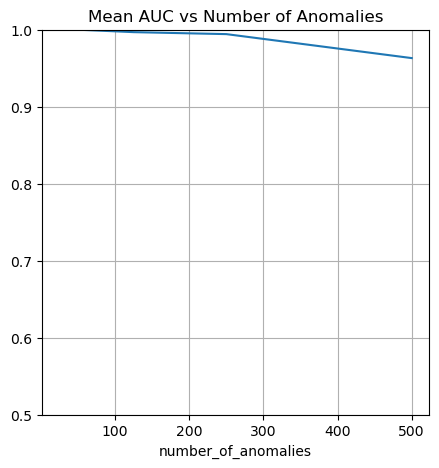

In [43]:
dfm = df.groupby(['number_of_anomalies','lda_1', 'lda_t', 'lda_l'])[['auc', 'rec_err']].mean()
dfm2 = dfm.groupby(['number_of_anomalies'])['auc'].max()
# display(HTML(dfm.to_html()))
fig = plt.figure(figsize=(5,5))
dfm2.plot()
plt.grid()
plt.title("Mean AUC vs Number of Anomalies");
plt.ylim([0.5,1]);
# dfm[dfm['auc'==dfm2[0,1]]]
# dfm['auc'].argmax()

In [13]:
client.shutdown()

2023-06-26 09:37:01,035 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 251.92 MiB -- Worker memory limit: 327.68 MiB
2023-06-26 09:37:01,235 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/mnt/home/indibimu/miniconda3/lib/python3.9/site-packages/distributed/worker.py", line 1238, in heartbeat
    response = await retry_operation(
  File "/mnt/home/indib